# Analyse Exploratoire

### Import des modules

In [419]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from sklearn.preprocessing import StandardScaler

import folium

In [489]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Analyse Exploratoire

In [421]:
FILE_PATH = r'data\2016_Building_Energy_Benchmarking.csv'

In [422]:
data = pd.read_csv(FILE_PATH)

In [423]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [424]:
data.duplicated().sum()

0

In [425]:
data['OSEBuildingID'].duplicated().sum()

0

In [426]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### 1. Valeurs manquantes

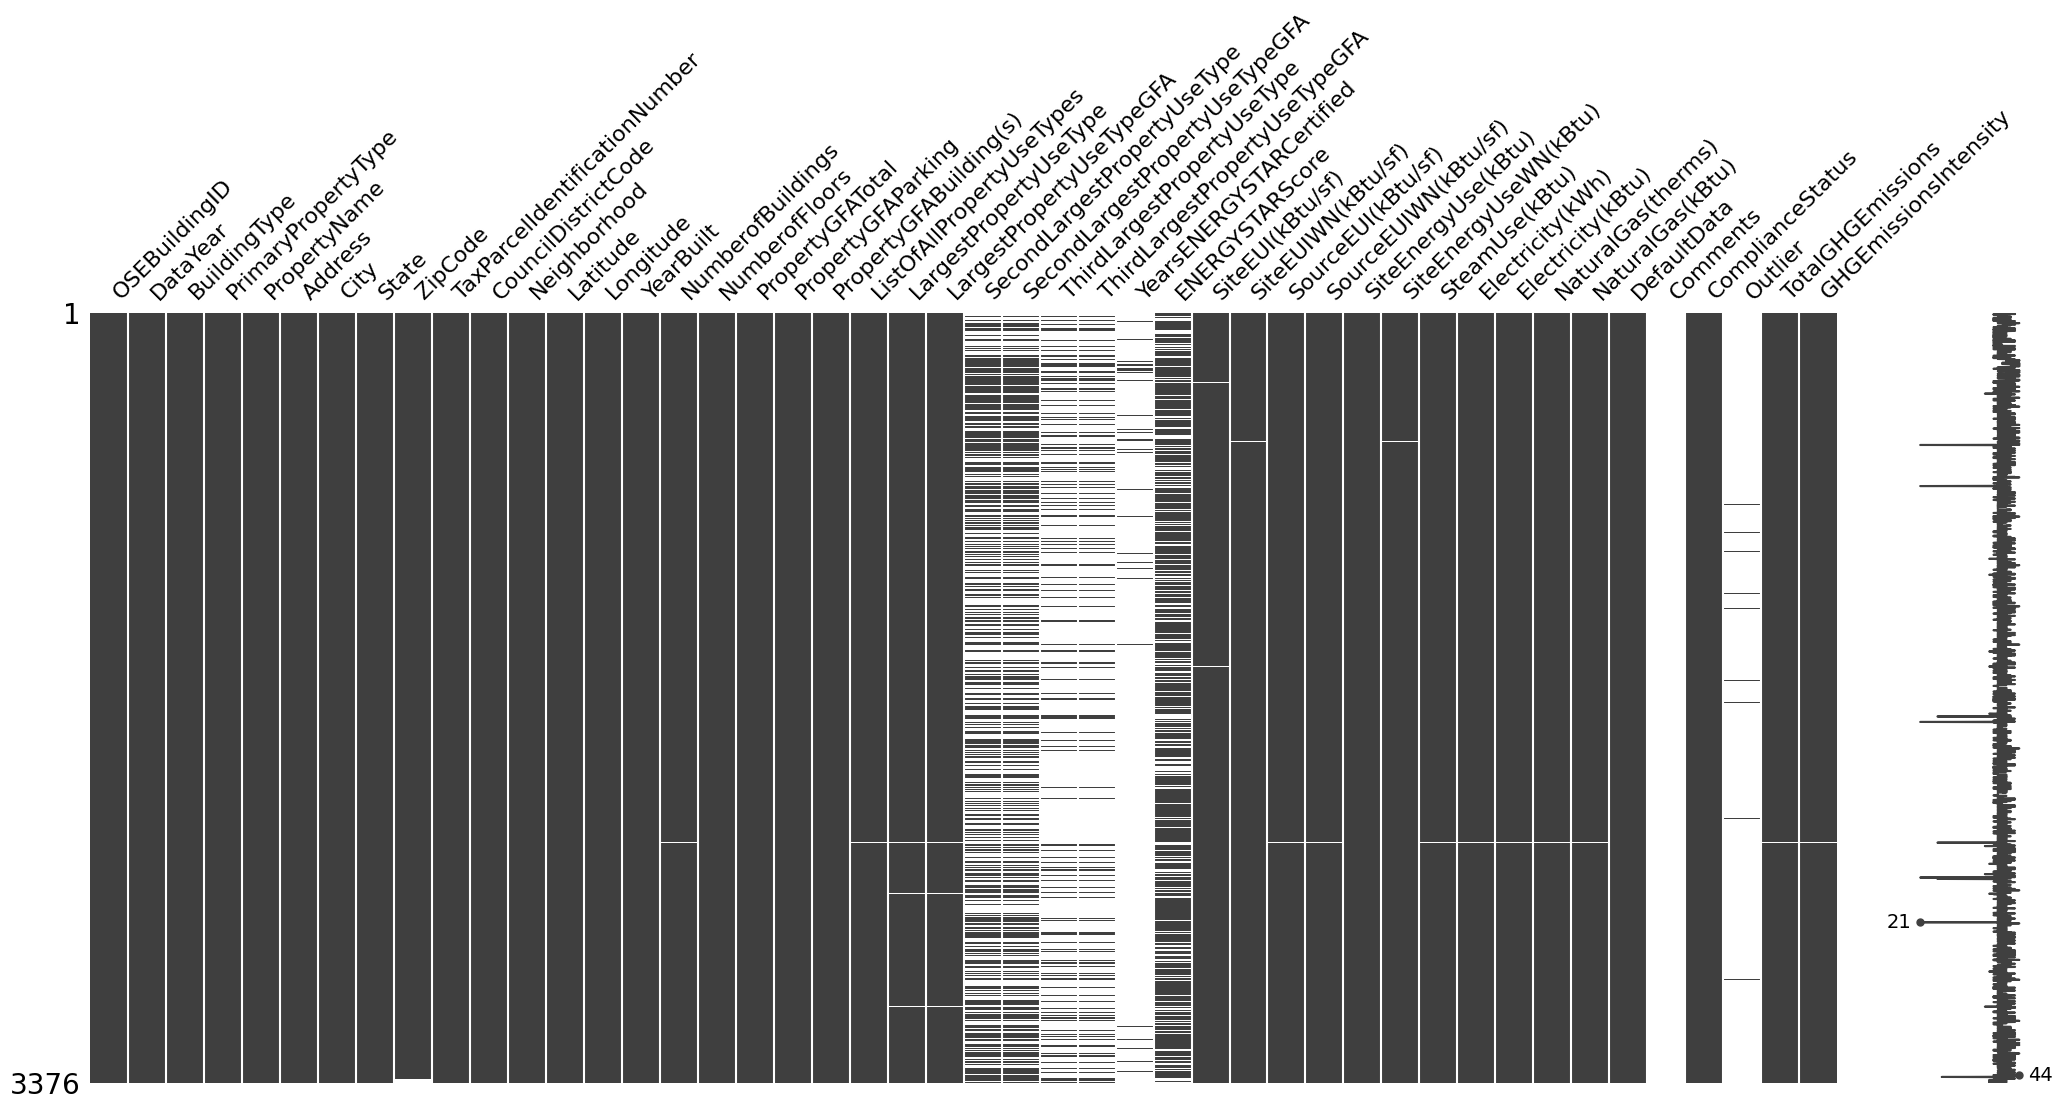

In [427]:
msno.matrix(data);

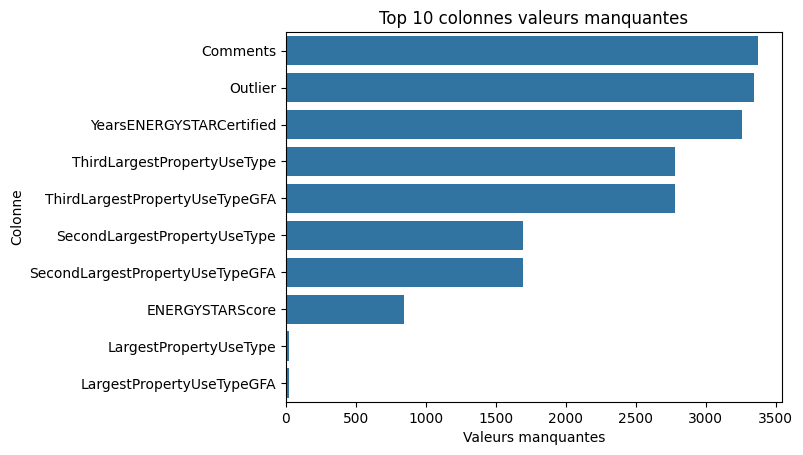

                           Colonne  Valeurs manquantes
0                         Comments                3376
1                          Outlier                3344
2         YearsENERGYSTARCertified                3257
3      ThirdLargestPropertyUseType                2780
4   ThirdLargestPropertyUseTypeGFA                2780
5     SecondLargestPropertyUseType                1697
6  SecondLargestPropertyUseTypeGFA                1697
7                  ENERGYSTARScore                 843
8           LargestPropertyUseType                  20
9        LargestPropertyUseTypeGFA                  20


In [428]:
df = data.isnull().sum().nlargest(10).reset_index()
df.columns = ['Colonne', 'Valeurs manquantes']

sns.barplot(x=df['Valeurs manquantes'], y=df['Colonne'])
plt.title('Top 10 colonnes valeurs manquantes')
plt.show();

print(df)

del df

In [429]:
data[~data['Outlier'].isnull()].head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,...,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,...,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,...,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19


* La colonne comments est complement vide.
* La colonne `Outlier` nous renseigne sur le type d'outlier (low/high) mais pas très intéressante pour notre modèle.

In [430]:
data = data.drop(columns=['Comments', 'Outlier'])

### 2. Filtrage du type de bâtiment

* Nous ne voulons garder que les bâtiments non-residentiel pour notre étude

In [431]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [432]:
# Creating a wrapper to count the numbers of rows before/after and the number of rows affected.
def affected_rows(func):
    def wrapper(*args, **kwargs):
        df = args[0]
        initial_row_count = df.shape[0]
        result = func(*args, **kwargs)
        final_row_count = result.shape[0]
        print(f"Rows before operation: {initial_row_count}, Rows after: {final_row_count}, Number of rows affected: {initial_row_count - final_row_count}")
        return result
    return wrapper

In [433]:
@affected_rows
def filter_dataframe(df: pd.DataFrame, column: str, values: list[str]) -> pd.DataFrame:
    return df[~df[column].isin(values)] 

In [434]:
type_to_filter = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']

data = filter_dataframe(data, 'BuildingType', type_to_filter)

del type_to_filter

Rows before operation: 3376, Rows after: 1668, Number of rows affected: 1708


In [435]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

* Il reste des bâtiments destinés à l'habitation.
* On va les filtrer sur la base de `PrimaryPropertyType`

In [436]:
type_to_filter = ['Residence Hall', 'Low-Rise Multifamily']

data = filter_dataframe(data, 'PrimaryPropertyType', type_to_filter)

del type_to_filter

Rows before operation: 1668, Rows after: 1644, Number of rows affected: 24


### 3. Filtrage de colonnes inutiles

* Il ya trois colonnes qui ne contiennent aucunes informations, on va les retirer.

In [437]:
display(set(data['City']))
display(set(data['DataYear']))
display(set(data['State']))

{'Seattle'}

{2016}

{'WA'}

In [438]:
data['DefaultData'].value_counts()

DefaultData
False    1556
True       88
Name: count, dtype: int64

* La colonne `DefaultData` ne semble pas fournir d'informations intéressantes. 
* Elle nous dit que une valeur par defaut a été utilisé pour une des colonnes, mais elle ne nous dit pas laquelle.

In [439]:
data = data.drop(columns=['City', 'DataYear', 'State', 'DefaultData'])

In [440]:
data.head(3)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,...,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,Compliant,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,...,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,Compliant,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,...,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,Compliant,2089.28,2.19


In [441]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [442]:
data = data.drop(columns=['OSEBuildingID', 'PropertyName', 'TaxParcelIdentificationNumber'])

In [443]:
data.isnull().sum().nlargest(10)

YearsENERGYSTARCertified           1546
ThirdLargestPropertyUseType        1294
ThirdLargestPropertyUseTypeGFA     1294
SecondLargestPropertyUseType        797
SecondLargestPropertyUseTypeGFA     797
ENERGYSTARScore                     570
ZipCode                              16
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SiteEUI(kBtu/sf)                      3
dtype: int64

> "tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels **elles n’ont pas encore été mesurées**."

* On doit donc retirer les variables relative à l'énergie, sinon cela introduirait du `dataleak`.
* On ne garde que notre variable cible.

In [444]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [445]:
energy_columns = ['ENERGYSTARScore', 
                  'YearsENERGYSTARCertified',
                  'SiteEUI(kBtu/sf)',
                  'SiteEUIWN(kBtu/sf)',
                  'SourceEUI(kBtu/sf)', 
                  'SourceEUIWN(kBtu/sf)', 
                  'SiteEnergyUse(kBtu)',
                  'SiteEnergyUseWN(kBtu)', 
                  'SteamUse(kBtu)', 
                  'Electricity(kWh)',
                  'Electricity(kBtu)', 
                  'NaturalGas(therms)', 
                  'NaturalGas(kBtu)',
                  'ComplianceStatus', 
                  'GHGEmissionsIntensity',
                  'PropertyGFATotal']
                  

data = data.drop(columns=energy_columns)

In [446]:
data.head(3)

,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions
0,NonResidential,Hotel,405 Olive way,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,...,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,249.98
1,NonResidential,Hotel,724 Pine street,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,...,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,295.86
2,NonResidential,Hotel,1900 5th Avenue,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,...,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,2089.28


### 4. Outliers

In [447]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'TotalGHGEmissions'],
      dtype='object')

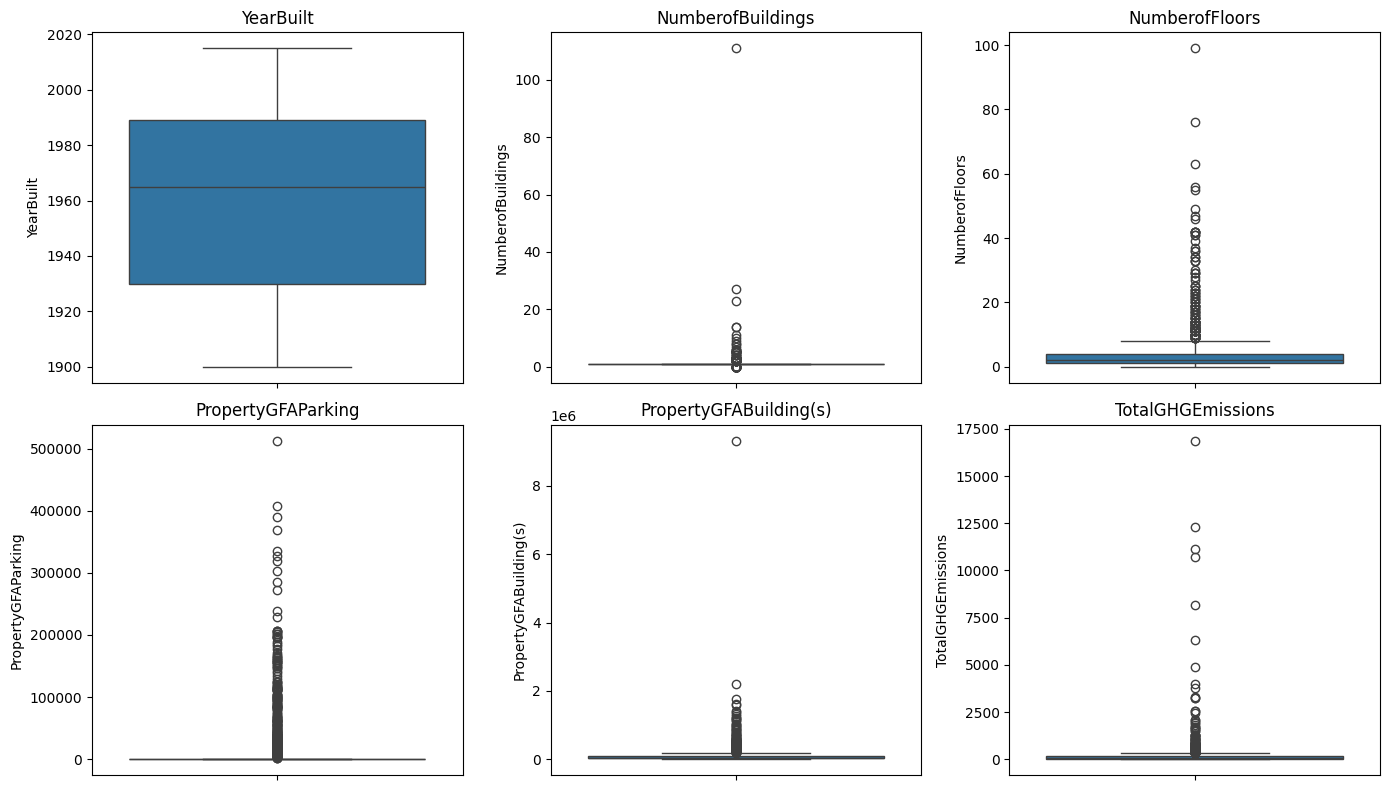

In [448]:
cols = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)','TotalGHGEmissions']

fig, ax = plt.subplots(2,3,figsize=(14, 8))
ax = ax.flatten()

for i, col in enumerate(cols):   
    sns.boxplot(data=data[col], ax=ax[i])
    ax[i].set_title(col)
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [449]:
data[cols].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),TotalGHGEmissions
count,1644.000000,1642.000000,1644.000000,1644.000000,1.644000e+03,1642.000000
mean,1961.935523,1.171742,4.128345,13020.979319,1.065119e+05,186.347004
std,32.667501,2.952557,6.600039,42546.712887,2.861678e+05,757.276699
min,1900.000000,0.000000,0.000000,0.000000,3.636000e+03,-0.800000
25%,1930.000000,1.000000,1.000000,0.000000,2.849800e+04,19.882500
50%,1965.000000,1.000000,2.000000,0.000000,4.755700e+04,49.485000
75%,1989.000000,1.000000,4.000000,0.000000,9.455325e+04,143.102500
max,2015.000000,111.000000,99.000000,512608.000000,9.320156e+06,16870.980000


* Certains bâtiments affiche des valeurs négatives ou null pour la production de CO2 que l'on retire.
* D'autres sont affichés avec 0 bâtiments et étages

In [450]:
print(f"Lignes avec 0 bâtiments: {data[data['NumberofBuildings'] <= 0].shape[0]}")
print(f"Lignes avec 0 étages: {data[data['NumberofFloors'] <= 0].shape[0]}")

Lignes avec 0 bâtiments: 51
Lignes avec 0 étages: 12


In [451]:
data['NumberofBuildings'].value_counts()

NumberofBuildings
1.0      1538
0.0        51
2.0        14
3.0        12
5.0         8
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: count, dtype: int64

In [452]:
data['NumberofFloors'].value_counts()

NumberofFloors
1     464
2     391
3     260
4     141
5     101
6      84
7      33
8      22
10     18
11     18
0      12
14      9
12      9
9       7
13      7
15      5
42      5
19      5
17      4
16      3
21      3
22      3
23      3
29      3
18      3
20      3
24      3
25      3
33      3
36      2
34      2
41      2
46      1
99      1
27      1
76      1
56      1
30      1
28      1
55      1
63      1
37      1
49      1
47      1
39      1
Name: count, dtype: int64

* Il n'y en majorité que 1 bâtiment et 1 étage.
* On va remplacer les valeurs à 0 par 1, puis transformer les deux colonnes en :
  * has_multiple_buildings
  * has_multiple_floors

In [453]:
data['has_multiple_buildings'] = (data['NumberofBuildings'] > 1).astype(int)
data['has_multiple_floors'] = (data['NumberofFloors'] > 1).astype(int)

In [454]:
data = data.drop(columns=['NumberofBuildings', 'NumberofFloors'])

In [455]:
data['has_multiple_buildings'].value_counts()

has_multiple_buildings
0    1591
1      53
Name: count, dtype: int64

In [456]:
data['has_multiple_floors'].value_counts()

has_multiple_floors
1    1168
0     476
Name: count, dtype: int64

In [457]:
data = data[data['TotalGHGEmissions'] > 0]

In [458]:
data.shape[0]

1635

In [459]:
iqr = np.quantile(data['TotalGHGEmissions'], [0.25, 0.75])

limite_basse = iqr[0] - 1.5 * (iqr[1] - iqr[0])
limite_haute = iqr[0] + 1.5 * (iqr[1] - iqr[0])

In [460]:
data = data[data['TotalGHGEmissions'] < limite_haute]

In [461]:
'''data['z_score_co2'] = StandardScaler().fit_transform(data[['TotalGHGEmissions']])
data[data['z_score_co2'] <= 2].shape[0]
data[data['z_score_co2'] >= 2].shape[0]
data = data[data['z_score_co2'] <= 2]'''

"data['z_score_co2'] = StandardScaler().fit_transform(data[['TotalGHGEmissions']])\ndata[data['z_score_co2'] <= 2].shape[0]\ndata[data['z_score_co2'] >= 2].shape[0]\ndata = data[data['z_score_co2'] <= 2]"

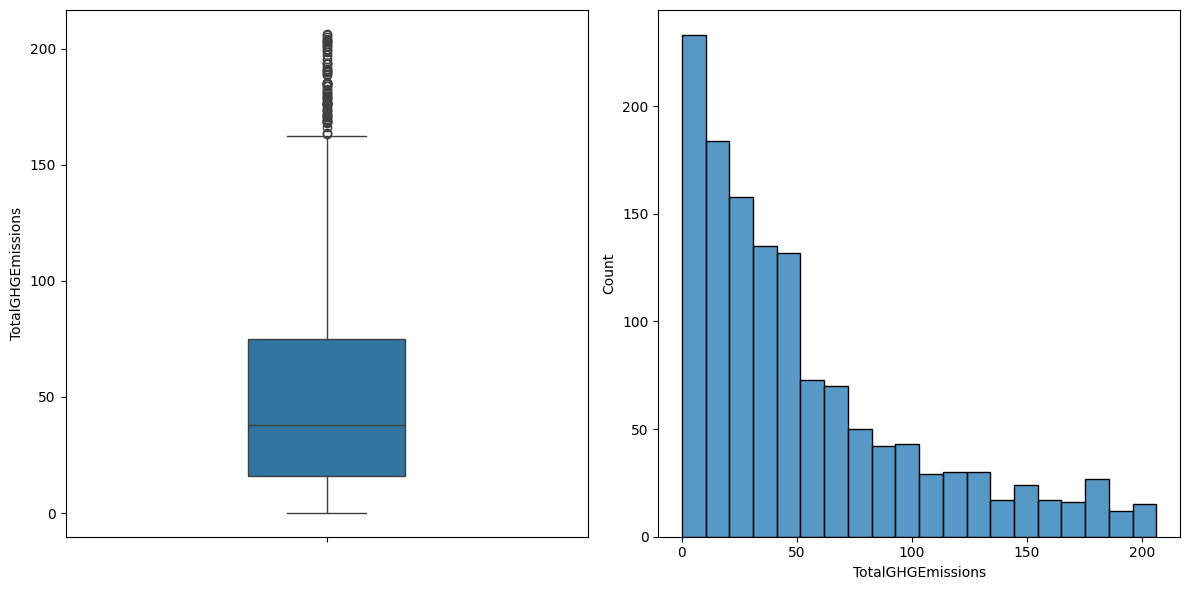

In [462]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.boxplot(data['TotalGHGEmissions'], width=0.3, ax=ax[0])
sns.histplot(data['TotalGHGEmissions'], ax=ax[1])

plt.tight_layout()
plt.show();

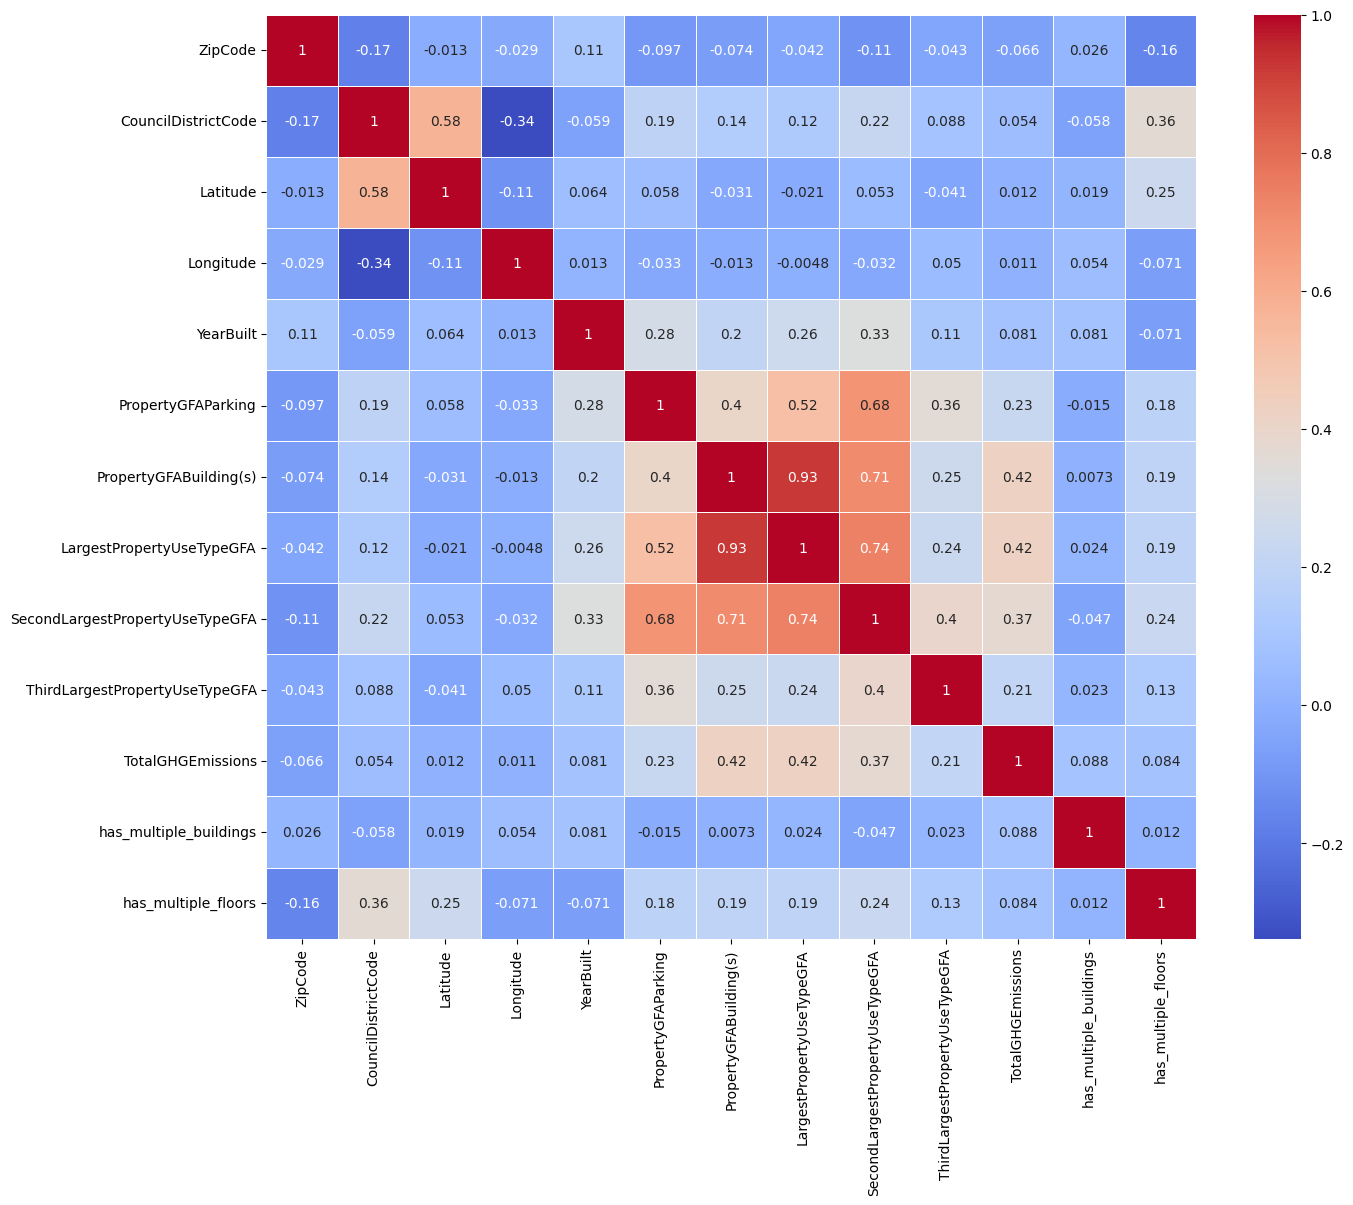

In [463]:
corr_table = data.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(corr_table, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show();

### 4. Localisation

In [464]:
data = data.drop(columns=['BuildingType',
                          'SecondLargestPropertyUseType',
                          'ThirdLargestPropertyUseType',
                          'SecondLargestPropertyUseTypeGFA',
                          'ThirdLargestPropertyUseTypeGFA',
                          'LargestPropertyUseTypeGFA'])

In [465]:
data.columns

Index(['PrimaryPropertyType', 'Address', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'TotalGHGEmissions', 'has_multiple_buildings', 'has_multiple_floors'],
      dtype='object')

In [466]:
data.isnull().sum()

PrimaryPropertyType           0
Address                       0
ZipCode                      13
CouncilDistrictCode           0
Neighborhood                  0
Latitude                      0
Longitude                     0
YearBuilt                     0
PropertyGFAParking            0
PropertyGFABuilding(s)        0
ListOfAllPropertyUseTypes     0
LargestPropertyUseType        4
TotalGHGEmissions             0
has_multiple_buildings        0
has_multiple_floors           0
dtype: int64

In [467]:
data['Neighborhood'].value_counts()

Neighborhood
GREATER DUWAMISH          323
DOWNTOWN                  252
MAGNOLIA / QUEEN ANNE     123
LAKE UNION                109
NORTHEAST                  94
EAST                       91
NORTHWEST                  64
BALLARD                    53
NORTH                      47
CENTRAL                    46
SOUTHEAST                  38
DELRIDGE                   36
SOUTHWEST                  34
North                       8
Ballard                     6
Northwest                   5
Delridge                    4
Central                     3
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [468]:
data.loc[:, 'Neighborhood'] = data.loc[:, 'Neighborhood'].str.lower()

In [469]:
data

,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,TotalGHGEmissions,has_multiple_buildings,has_multiple_floors
6,Hotel,1619 9th Avenue,98101.0,7,downtown,47.61390,-122.33283,1926,0,83008,Hotel,Hotel,176.14,0,1
15,Other,1000 Fourth Avenue,98154.0,7,downtown,47.60649,-122.33297,2004,57000,355000,"Data Center, Library, Parking",Library,181.38,0,1
22,K-12 School,5149 S. Graham St.,98118.0,2,southeast,47.54576,-122.26853,1961,0,56228,K-12 School,K-12 School,38.53,0,1
23,Hotel,4242 ROOSEVELT WAY NE,98105.0,4,northeast,47.65959,-122.31755,2001,30586,58006,"Hotel, Parking",Hotel,90.01,0,1
25,Other,1015 & 1017 Olive Way,98101.0,7,downtown,47.61500,-122.33081,1930,0,67224,Automobile Dealership,Automobile Dealership,9.13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,Other,6920 34th Ave SW,NaN,1,delridge neighborhoods,47.54067,-122.37441,1982,0,18261,Other - Recreation,Other - Recreation,20.33,0,0
3371,Office,1600 S Dakota St,NaN,2,greater duwamish,47.56722,-122.31154,1990,0,12294,Office,Office,20.94,0,0
3372,Other,719 8th Ave S,NaN,2,downtown,47.59625,-122.32283,2004,0,16000,Other - Recreation,Other - Recreation,32.17,0,0
3374,Mixed Use Property,8319 8th Ave S,NaN,1,greater duwamish,47.52832,-122.32431,1989,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,22.11,0,0


In [470]:
data.loc[data['Neighborhood'] == 'delridge neighborhoods', 'Neighborhood'] = 'delridge'

In [471]:
data.loc[:, 'YearBuilt'] = 2016 - data['YearBuilt']

In [472]:
data['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  428
Non-Refrigerated Warehouse                              194
K-12 School                                             118
Retail Store                                             88
Other                                                    76
Worship Facility                                         70
Distribution Center                                      52
Hotel                                                    37
Medical Office                                           30
Self-Storage Facility                                    27
Other - Recreation                                       21
Parking                                                  21
Supermarket/Grocery Store                                18
College/University                                       15
Other - Entertainment/Public Assembly                    13
Refrigerated Warehouse                                   12
Senior Care Commu

In [473]:
data.columns

Index(['PrimaryPropertyType', 'Address', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'TotalGHGEmissions', 'has_multiple_buildings', 'has_multiple_floors'],
      dtype='object')

In [474]:
X = data.loc[:,['CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'PropertyGFAParking', 'PropertyGFABuilding(s)','has_multiple_buildings', 'has_multiple_floors']].reset_index(drop=True)

y = data.loc[:,'TotalGHGEmissions']

In [475]:
encoder = OneHotEncoder(sparse_output=False)

neighborhood_encoded = encoder.fit_transform(X[['Neighborhood']])

neighborhood_feature_names = encoder.get_feature_names_out(['Neighborhood'])

df = pd.DataFrame(data=neighborhood_encoded, columns=neighborhood_feature_names)

In [476]:
X = pd.concat([X, df],axis=1)

In [477]:
X = X.drop(columns='Neighborhood')

In [478]:
X[X['PropertyGFAParking'] == 0].shape[0]
X[X['PropertyGFAParking'] > 0].shape[0]

233

In [479]:
X['has_a_parking'] = (X['PropertyGFAParking'] > 0).astype(int)

In [480]:
X = X.drop(columns=['PropertyGFAParking', 'CouncilDistrictCode'])

In [508]:
X.isnull().sum()

YearBuilt                             0
PropertyGFABuilding(s)                0
has_multiple_buildings                0
has_multiple_floors                   0
Neighborhood_ballard                  0
Neighborhood_central                  0
Neighborhood_delridge                 0
Neighborhood_downtown                 0
Neighborhood_east                     0
Neighborhood_greater duwamish         0
Neighborhood_lake union               0
Neighborhood_magnolia / queen anne    0
Neighborhood_north                    0
Neighborhood_northeast                0
Neighborhood_northwest                0
Neighborhood_southeast                0
Neighborhood_southwest                0
has_a_parking                         0
dtype: int64

In [482]:
scaler = StandardScaler()

X.loc[:, 'YearBuilt'] = X.loc[:, 'YearBuilt'].astype(float)
X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']] = scaler.fit_transform(X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']])

C:\Users\GCFH8598\AppData\Local\Temp\ipykernel_22460\570308785.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.04092118 -1.36293874 -0.03773391 ... -1.36293874 -0.90065798
  0.67109658]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']] = scaler.fit_transform(X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']])
C:\Users\GCFH8598\AppData\Local\Temp\ipykernel_22460\570308785.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.3334867   4.54182157 -0.08086081 ... -0.70327947 -0.73266132
 -0.66834308]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']] = scaler.fit_transform(X.loc[:, [ 'YearBuilt', 'PropertyGFABuilding(s)']])


In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [485]:
reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [486]:
y_pred_test = reg.predict(X_test)

In [490]:
RMSE = mean_squared_error(y_pred_test, y_test)

MAPE = mean_absolute_percentage_error(y_pred_test, y_test)

print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}")

RMSE: 1738.2219762323816
MAPE: 0.6148689434447995


In [491]:
reg.score(X_train, y_train)

0.19301183434637037

In [492]:
reg.score(X_test, y_test)

0.2488010600900099

In [507]:
pd.DataFrame(data=abs(reg.coef_), index=reg.feature_names_in_, columns=['Coefficient']).sort_values(ascending=False, by='Coefficient')

,Coefficient
PropertyGFABuilding(s),21.698006
has_multiple_buildings,20.244993
Neighborhood_east,20.149647
Neighborhood_southeast,14.293069
Neighborhood_southwest,14.068582
Neighborhood_lake union,9.865795
Neighborhood_northeast,9.404211
Neighborhood_north,8.671434
Neighborhood_greater duwamish,8.120528
Neighborhood_ballard,7.030938


In [500]:
reg.feature_names_in_

array(['YearBuilt', 'PropertyGFABuilding(s)', 'has_multiple_buildings',
       'has_multiple_floors', 'Neighborhood_ballard',
       'Neighborhood_central', 'Neighborhood_delridge',
       'Neighborhood_downtown', 'Neighborhood_east',
       'Neighborhood_greater duwamish', 'Neighborhood_lake union',
       'Neighborhood_magnolia / queen anne', 'Neighborhood_north',
       'Neighborhood_northeast', 'Neighborhood_northwest',
       'Neighborhood_southeast', 'Neighborhood_southwest',
       'has_a_parking'], dtype=object)

In [ ]:
### Random Forest

In [496]:
model = RandomForestRegressor(200)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [497]:
y_pred_test = model.predict(X_test)

In [498]:
RMSE = mean_squared_error(y_pred_test, y_test)

MAPE = mean_absolute_percentage_error(y_pred_test, y_test)

print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}")

RMSE: 1904.1648596837235
MAPE: 0.7509858960305221


# Modélisation 

### Import des modules 

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

In [ ]:
# CODE FEATURE ENGINEERING

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [ ]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [1]:
# CODE COMPARAISON DES MODELES

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [ ]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE